正在使用 Shapely 2.0 原生解析器计算...
------------------------------
【计算成功】
几何质心: (108.86987969907955, 35.19393459988484)
包围中心: (108.367283, 35.647542)
------------------------------


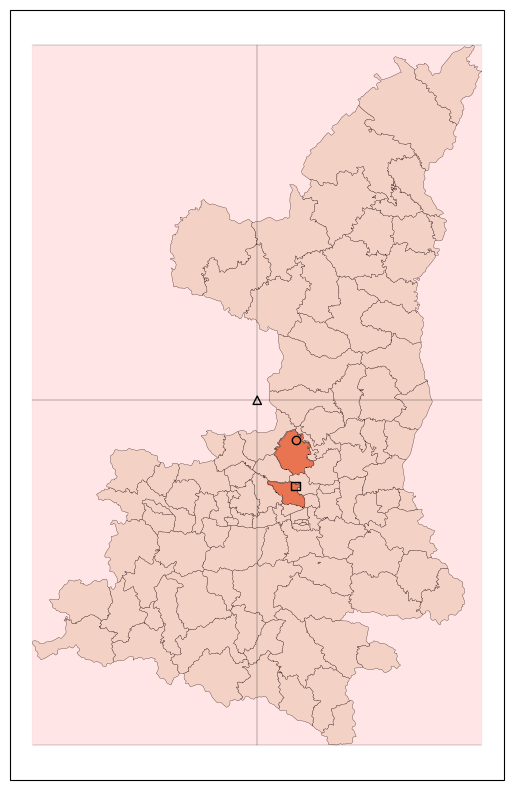

In [4]:

import shapely
import geopandas as gpd
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pyproj

plt.rcParams['font.sans-serif'] = ['SimHei','Times New Roman']
plt.rcParams['axes.unicode_minus'] = False 


def loopFillColor(ax, world, countryList, color):
    for country in countryList:
        country_data = world[world['name'] == country]
        if not country_data.empty:
            country_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.2, zorder=3)


def get_centroid_v2(geojson_path):
    
    with open(geojson_path, 'r', encoding='utf-8') as f:
        geojson_str = f.read()

    geometry_collection = shapely.from_geojson(geojson_str)
    centroid = geometry_collection.centroid
    
    minx, miny, maxx, maxy = geometry_collection.bounds
    bbox_center_lon = (minx + maxx) / 2
    bbox_center_lat = (miny + maxy) / 2

    return {
        "centroid": (centroid.x, centroid.y),
        "bbox_center": (bbox_center_lon, bbox_center_lat),
        "bounds": (minx, miny, maxx, maxy)
    }

# --- 测试 ---
file_path = './chinamap/陕西省_县.geojson'

try:
    print("正在使用 Shapely 2.0 原生解析器计算...")
    centers = get_centroid_v2(file_path)
    
    print("-" * 30)
    print("【计算成功】")
    print(f"几何质心: {centers['centroid']}")
    print(f"包围中心: {centers['bbox_center']}")
    print("-" * 30)
    
    # 人口密度中心 外部计算结果
    pop_cen_lon, pop_cen_lat = 108.857698, 34.681622

    target_projection = ccrs.Miller(central_longitude=150)
    county = gpd.read_file('./chinamap/陕西省_县.geojson')
    county = county.to_crs(target_projection)
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': target_projection})
    county.plot(ax=ax, color='#F2E9DC', edgecolor='black', linewidth=0.2)

    cityList = ['泾阳县', '耀州区']
    loopFillColor(ax, county, cityList, "#E97451")

    coords = [(centers['bounds'][0], centers['bounds'][3]), (centers['bounds'][2], centers['bounds'][3]), (centers['bounds'][2], centers['bounds'][1]), (centers['bounds'][0], centers['bounds'][1])]
    polygon = Polygon(coords)
    gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
    try:
        gdf_transformed = gdf.to_crs(target_projection.proj4_init)
    except:
        gdf_transformed = gdf.to_crs(target_projection)

    gdf_transformed.plot(ax=ax, color='r', alpha=0.1, edgecolor='k', linewidth=0.2)

    transformer = pyproj.Transformer.from_crs("epsg:4326", target_projection.proj4_init, always_xy=True)
    bbox_x, bbox_y = transformer.transform(centers['bbox_center'][0], centers['bbox_center'][1])
    cen_x, cen_y = transformer.transform(centers['centroid'][0], centers['centroid'][1])
    pop_x, pop_y = transformer.transform(pop_cen_lon, pop_cen_lat)

    ax.scatter(bbox_x, bbox_y, color='none', edgecolor='k', marker='^', zorder=15)
    ax.scatter(cen_x, cen_y, color='none', edgecolor='k', marker='o', zorder=30)
    ax.scatter(pop_x, pop_y, color='none', edgecolor='k', marker='s', zorder=45)

    minx, miny, maxx, maxy = centers['bounds']
    cx, cy = centers['bbox_center']
    x1, y1 = transformer.transform(cx, miny)
    x2, y2 = transformer.transform(cx, maxy)
    ax.plot([x1, x2], [y1, y2], color='k', linewidth=0.2, zorder=10)

    x3, y3 = transformer.transform(minx, cy)
    x4, y4 = transformer.transform(maxx, cy)
    ax.plot([x3, x4], [y3, y4], color='k', linewidth=0.2, zorder=10)

    plt.savefig('shannxi_s4.png', dpi=1200, bbox_inches='tight')
    
    
except Exception as e:
    import traceback
    print("如果还报错，那就是环境彻底坏了：")
    traceback.print_exc()

正在进行投影转换 (WGS84 -> Custom Projection)...
正在计算难抵极 (Pole of Inaccessibility)...
------------------------------
【精确计算结果】
难抵极经度: 108.085560
难抵极纬度: 33.717987
距边界距离: 140.01 公里
------------------------------


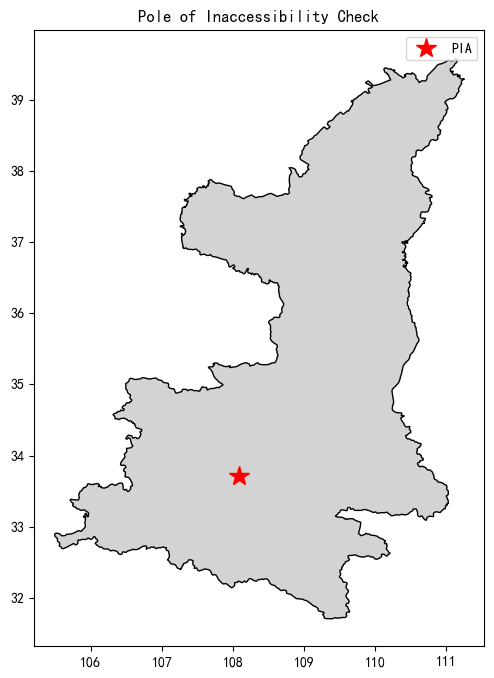

In [ ]:
# !/usr/bin/env python3
# 求最大内切圆

import geopandas as gpd
from shapely.ops import polylabel
import matplotlib.pyplot as plt

def get_precise_pia_modern(geojson_path):
    # --- 1. 读取数据 (一行代码代替原来的 json.load + shape) ---
    gdf = gpd.read_file(geojson_path)
    
    # 确保原始数据有坐标系，如果没有默认为 WGS84
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)

    # --- 2. 定义投影 (使用你的自定义参数) ---
    # 陕西省比较狭长，使用你定义的兰伯特投影是合适的
    custom_crs = (
        "+proj=lcc +lat_1=32.73 +lat_2=38.54 +lat_0=35 "
        "+lon_0=108.9 +datum=WGS84 +units=m +no_defs"
    )
    
    # --- 3. 投影转换 (GeoPandas 自动处理) ---
    print("正在进行投影转换 (WGS84 -> Custom Projection)...")
    gdf_projected = gdf.to_crs(custom_crs)

    # --- 4. 提取最大几何体 (处理飞地/岛屿) ---
    # 将 MultiPolygon 炸开成多个 Polygon
    exploded = gdf_projected.explode(index_parts=False)
    # 计算面积并按面积降序排列，取最大的那个作为主体
    exploded['area'] = exploded.area
    main_polygon_geom = exploded.sort_values('area', ascending=False).geometry.iloc[0]

    # 修复可能的拓扑错误 (Buffer 0)
    if not main_polygon_geom.is_valid:
        print("正在修复拓扑错误...")
        main_polygon_geom = main_polygon_geom.buffer(0)

    # --- 5. 计算难抵极 (单位: 米) ---
    print("正在计算难抵极 (Pole of Inaccessibility)...")
    # tolerance=100 表示精度控制在 100米
    pia_point_meters = polylabel(main_polygon_geom, tolerance=100)
    
    # 计算最大内切圆半径 (米)
    radius_meters = main_polygon_geom.exterior.distance(pia_point_meters)

    # --- 6. 将结果点转回经纬度 ---
    # 创建一个包含该点的 GeoSeries 方便转回
    pia_gs = gpd.GeoSeries([pia_point_meters], crs=custom_crs)
    pia_wgs84 = pia_gs.to_crs(epsg=4326).iloc[0]

    return {
        "lon": pia_wgs84.x,
        "lat": pia_wgs84.y,
        "radius_km": radius_meters / 1000,
        "point_geom": pia_wgs84,       # 用于可视化的点
        "poly_geom": gdf.geometry[0]   # 用于可视化的省界
    }

# --- 执行代码 ---
file_path = './chinamap/陕西省_省.geojson'

try:
    result = get_precise_pia_modern(file_path)
    
    print("-" * 30)
    print("【精确计算结果】")
    print(f"难抵极经度: {result['lon']:.6f}")
    print(f"难抵极纬度: {result['lat']:.6f}")
    print(f"距边界距离: {result['radius_km']:.2f} 公里")
    print("-" * 30)

    # --- 顺便画个简单的验证图 ---
    # 只要你环境里有 matplotlib，这段可以帮你直观确认位置对不对
    fig, ax = plt.subplots(figsize=(6, 8))
    gpd.GeoSeries([result['poly_geom']]).plot(ax=ax, color='lightgray', edgecolor='black')
    ax.plot(result['lon'], result['lat'], 'r*', markersize=15, label='PIA')
    plt.legend()
    plt.title("Pole of Inaccessibility Check")
    plt.show()

except Exception as e:
    print(f"发生错误: {e}")

In [6]:
#!/usr/bin/env python3
# 求最小外接圆

import geopandas as gpd
import numpy as np
import miniball
import pyproj
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Geod

# 设置中文字体，防止绘图乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def get_geodesic_bounding_circle_final(geojson_path, max_iterations=10, tolerance_m=1.0):
    """
    计算地理多边形的最小外接圆 (Geodesic Minimum Bounding Circle)
    使用迭代 AEQD 投影 + 凸包优化 + miniball
    """
    
    # --- 1. 读取与预处理 ---
    print(f"正在读取文件: {geojson_path}")
    gdf = gpd.read_file(geojson_path)
    
    # 确保有坐标系，默认为 WGS84
    if gdf.crs is None:
        gdf.set_crs(epsg=4326, inplace=True)

    # 处理 MultiPolygon (取面积最大的主体)
    if gdf.geometry.iloc[0].geom_type == 'MultiPolygon':
        exploded = gdf.explode(index_parts=False)
        # 临时转投影计算面积，避免 UserWarning
        exploded['area'] = exploded.to_crs(exploded.estimate_utm_crs()).area
        target_polygon = exploded.sort_values('area', ascending=False).geometry.iloc[0]
    else:
        target_polygon = gdf.geometry.iloc[0]

    # --- 2. 关键优化：取凸包并去重 (解决 Singular matrix 报错的核心) ---
    print("正在计算凸包并清洗数据...")
    
    # 取凸包：最小外接圆只由凸包决定，这一步极大简化了形状
    hull_geom = target_polygon.convex_hull
    
    # 转为列表再转 numpy，避开 numpy 版本警告
    raw_coords = list(hull_geom.exterior.coords)
    
    # 强制去重：axis=0 表示按坐标点去重，去除首尾闭合点
    coords_wgs84 = np.unique(np.array(raw_coords), axis=0)
    
    # 防御性检查：如果点太少(比如三角形退化)，回退到原始点
    if len(coords_wgs84) < 3:
        print("警告：凸包点数过少，回退使用原始边界点...")
        raw_coords = list(target_polygon.exterior.coords)
        coords_wgs84 = np.unique(np.array(raw_coords), axis=0)

    print(f"优化完毕：计算点数从 {len(target_polygon.exterior.coords)} 减少到 {len(coords_wgs84)}")

    # --- 3. 初始猜测 ---
    initial_centroid = target_polygon.centroid
    center_lon, center_lat = initial_centroid.x, initial_centroid.y
    current_radius_m = 0
    
    # --- 4. 迭代计算 ---
    print("开始迭代计算 (Iterative AEQD)...")
    
    for i in range(max_iterations):
        # 建立以当前猜测中心为原点的 AEQD 投影
        proj_str = f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
        crs_aeqd = pyproj.CRS.from_proj4(proj_str)
        crs_wgs84 = pyproj.CRS('EPSG:4326')
        
        # 建立转换器
        to_aeqd = pyproj.Transformer.from_crs(crs_wgs84, crs_aeqd, always_xy=True)
        to_wgs84 = pyproj.Transformer.from_crs(crs_aeqd, crs_wgs84, always_xy=True)
        
        # 投影所有凸包点到平面
        xx, yy = to_aeqd.transform(coords_wgs84[:, 0], coords_wgs84[:, 1])
        points_projected = np.column_stack((xx, yy))
        
        # 调用 miniball 求解平面最小外接圆
        # C 是相对当前中心的偏移量 (x, y)
        C, r2 = miniball.get_bounding_ball(points_projected)
        current_radius_m = math.sqrt(r2)
        
        # 计算新中心的经纬度
        new_lon, new_lat = to_wgs84.transform(C[0], C[1])
        
        # 计算偏移距离 (用于判断收敛)
        shift = math.sqrt(C[0]**2 + C[1]**2)
        
        print(f"  迭代 {i+1}: 偏移 {shift:.2f}m -> 半径 {current_radius_m/1000:.3f}km")
        
        # 更新中心
        center_lon, center_lat = new_lon, new_lat
        
        if shift < tolerance_m:
            print(">>> 算法已收敛！")
            break
    
    return {
        "lon": center_lon,
        "lat": center_lat,
        "radius_km": current_radius_m / 1000,
        "polygon_geom": target_polygon # 返回几何体用于绘图
    }

# --- 主程序执行 ---

# 请将此处路径替换为你的真实文件路径
file_path = './chinamap/陕西省_省.geojson' 

try:
    # 1. 计算
    res = get_geodesic_bounding_circle_final(file_path)
    
    final_lon = res['lon']
    final_lat = res['lat']
    final_r = res['radius_km']
    
    print("-" * 30)
    print(f"【最终结果 (WGS84)】")
    print(f"圆心经度: {final_lon:.6f}")
    print(f"圆心纬度: {final_lat:.6f}")
    print(f"覆盖半径: {final_r:.4f} km")
    print("-" * 30)

    print("完成！")

except Exception as e:
    print("\n程序发生错误:")
    print(e)
    # 如果你需要详细报错信息，取消下面这行的注释
    # import traceback; traceback.print_exc()

正在读取文件: ./chinamap/陕西省_省.geojson
正在计算凸包并清洗数据...
优化完毕：计算点数从 1495 减少到 20
开始迭代计算 (Iterative AEQD)...
  迭代 1: 偏移 71807.07m -> 半径 460.594km
  迭代 2: 偏移 4.99m -> 半径 460.592km
  迭代 3: 偏移 0.00m -> 半径 460.592km
>>> 算法已收敛！
------------------------------
【最终结果 (WGS84)】
圆心经度: 108.864352
圆心纬度: 35.841106
覆盖半径: 460.5917 km
------------------------------
完成！


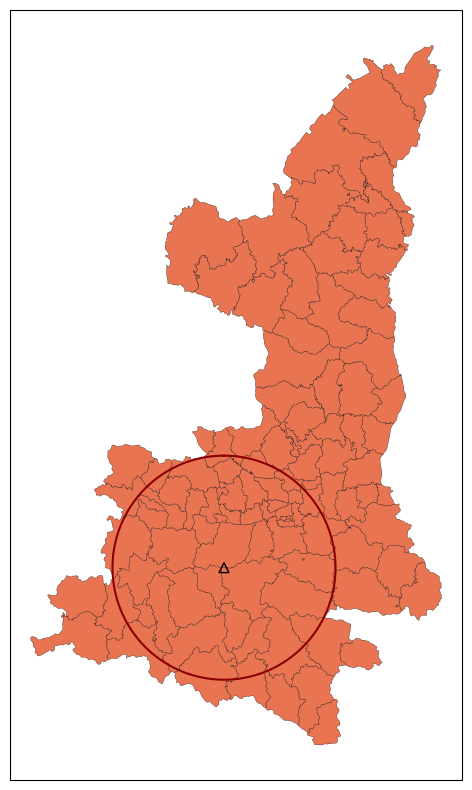

In [9]:
# 内切圆外接圆可视化

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from pyproj import Geod

# --- 1. 配置参数 ---
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

# 中心点坐标 (经度, 纬度)
# lon_center, lat_center = 108.864352, 35.841106
lon_center, lat_center =  108.085560,33.717987
# 圆圈半径 (公里)
# radius_km = 460.5917
radius_km = 140.01

# --- 2. 定义投影 ---
# 定义地图的投影方式 (正射投影)
target_projection = ccrs.Orthographic(central_longitude=lon_center, central_latitude=lat_center)

# --- 3. 读取数据 ---
# 直接读取 GeoJSON，默认保留为 WGS84 经纬度格式 (EPSG:4326)
# 这样最安全，画图时再交给 Cartopy 去处理投影
world = gpd.read_file('./chinamap/陕西省_县.geojson')
world = world.to_crs(target_projection)

# --- 4. 准备画图 ---
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': target_projection})

# (A) 画地图底图
# 关键：加上 transform=ccrs.PlateCarree()，告诉 ax "我给你的是经纬度数据"
world.plot(ax=ax, 
           color='#E97451', 
           edgecolor='black', 
           linewidth=0.2)

# (B) 画中心点 (三角形)
ax.scatter([lon_center], [lat_center], 
           color='none', 
           edgecolor='black', 
           marker='^', 
           s=50, 
           zorder=5,
           transform=ccrs.PlateCarree())

# --- 5. 高效画圆 (替代原来的 contour 循环) ---
# 使用 Geod 进行大地测量计算 (WGS84椭球)
g = Geod(ellps='WGS84')

# 生成 0 到 360 度的角度数组 (每隔 0.5 度一个点，够圆了)
azimuths = np.linspace(0, 360, 720) 
lons_center_arr = np.full_like(azimuths, lon_center)
lats_center_arr = np.full_like(azimuths, lat_center)
dists_arr = np.full_like(azimuths, radius_km * 1000)

transformer = pyproj.Transformer.from_crs("epsg:4326", target_projection.proj4_init, always_xy=True)

circle_lons, circle_lats, _ = g.fwd(lons_center_arr, lats_center_arr, azimuths, dists_arr)
circle_x, circle_y = transformer.transform(circle_lons, circle_lats)
ax.plot(circle_x, circle_y, 
        color='darkred', 
        linewidth=1.5, 
        zorder=4)

# --- 6. 导出与显示 ---
ax.tick_params(axis='both', which='both', length=0, labelsize=0)

# 如果你需要透明背景，可以在这里加 transparent=True
# plt.savefig('shannxi_s3.png', dpi=1200, bbox_inches='tight')
plt.show()

(np.float64(0.19215686274509805), np.float64(0.5098039215686274), np.float64(0.7411764705882353), np.float64(1.0))
['九寨沟县', '若尔盖县', '平武县', '华蓥市', '岳池县', '邻水县', '蓬溪县', '壤塘县', '大竹县', '达川区', '宣汉县', '开江县', '万源市', '阿坝县', '安岳县', '东兴区', '安居区', '色达县', '泸县', '合江县', '隆昌市', '叙永县', '古蔺县', '西区', '仁和区', '武胜县', '船山区', '盐边县', '兴文县', '朝天区', '青川县', '旺苍县', '会理市', '会东县', '宁南县', '盐源县', '叙州区', '高县', '屏山县', '南江县', '通江县', '木里藏族自治县', '稻城县', '珙县', '筠连县', '布拖县', '金阳县', '雷波县', '甘孜县', '德格县', '白玉县', '石渠县', '乡城县', '巴塘县', '得荣县']
(np.float64(0.7764705882352941), np.float64(0.8588235294117647), np.float64(0.9372549019607843), np.float64(1.0))
['松潘县', '红原县', '北川羌族自治县', '西充县', '蓬安县', '剑阁县', '马尔康市', '前锋区', '广安区', '巴州区', '恩阳区', '平昌县', '金川县', '康定市', '嘉陵区', '射洪市', '道孚县', '渠县', '高坪区', '通川区', '乐至县', '资中县', '雁江区', '炉霍县', '大英县', '富顺县', '龙马潭区', '江阳区', '纳溪区', '东区', '利州区', '昭化区', '米易县', '德昌县', '西昌市', '普格县', '冕宁县', '昭觉县', '翠屏区', '贡井区', '犍为县', '沐川县', '荣县', '苍溪县', '长宁县', '江安县', '江油市', '大安区', '市中区(内江市)', '雅江县', '九龙县', '理塘县', '马边彝族自治县',

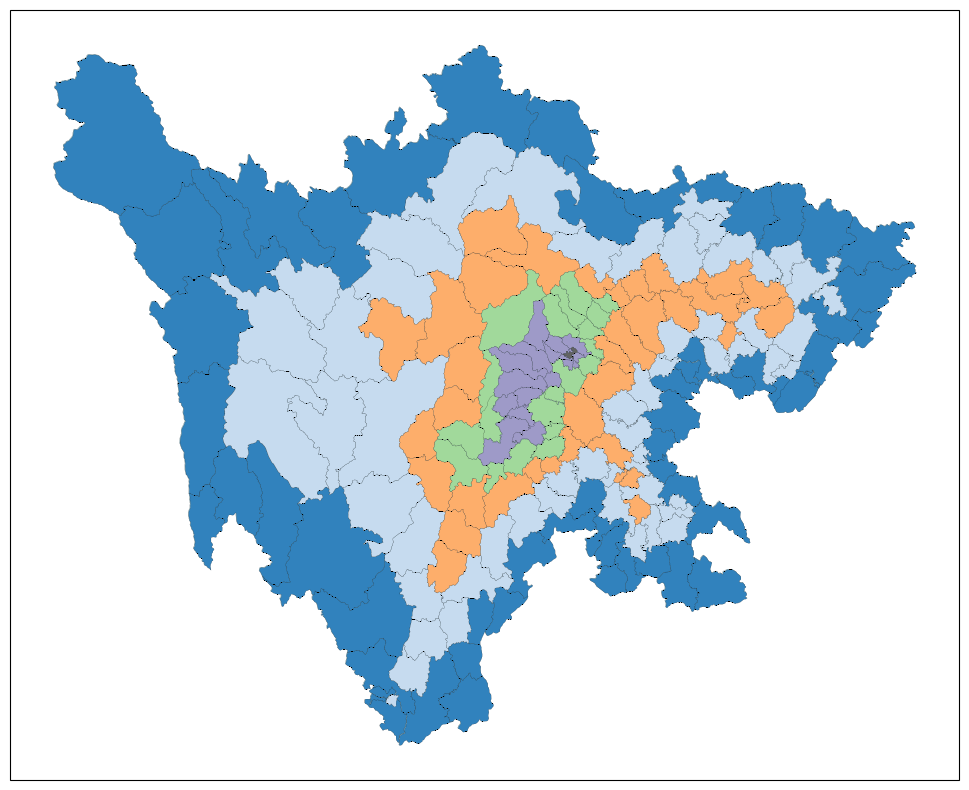

In [8]:
# 四川省专题
# 1、最内层的县级行政区划

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

target_projection = ccrs.Miller(central_longitude=150)

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax

# 读取地图数据
world = gpd.read_file('./chinamap/四川省_县.geojson')
world = world.to_crs(target_projection)

G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


# sichuan_border = [ '潼南区', '合川区', '渝北区', '长寿区', '垫江县', '梁平区', '万州区', '开州区', '城口县', '巫溪县', '巫山县', '奉节县', '云阳县', '石柱土家族自治县', 
#                    '彭水苗族土家族自治县', '黔江区', '酉阳土家族苗族自治县', '秀山土家族苗族自治县', '武隆区', '南川区', '綦江区', '江津区', '永川区', '荣昌区', '大足区']
sichuan_border = [ '古蔺县', '叙永县', '兴文县', '珙县', '筠连县', '高县', '叙州区', '屏山县', '雷波县', '金阳县', '布拖县', '宁南县', '会东县', '会理市', 
                   '仁和区', '西区', '盐边县', '盐源县', '木里藏族自治县', '稻城县', '乡城县', '得荣县', '巴塘县', '白玉县', '德格县', '石渠县', '色达县',
                   '甘孜县', '壤塘县', '阿坝县', '若尔盖县', '九寨沟县', '平武县', '青川县', '朝天区', '旺苍县', '南江县', '通江县', '万源市', '宣汉县', '开江县',
                   '达川区', '大竹县', '邻水县', '华蓥市', '岳池县', '武胜县', '蓬溪县', '船山区', '安居区', '安岳县', '东兴区', '隆昌市', '泸县', '合江县']

min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for e in sichuan_border:
    for state in G.nodes:
        if state is not e:
            try:
                steps = nx.shortest_path_length(G, source=state, target=e)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': target_projection})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.1)

stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=6)
scalarMap = cm.ScalarMappable(norm=norm, cmap='tab20c')

for i in range(0, 6):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.1)

# plt.savefig('sichuan_s1.png', dpi=1200, bbox_inches='tight')
plt.show()
